## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [45]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector, ColumnTransformer
from math import log
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from plotnine import *

In [46]:
heart_data = pd.read_csv("/Users/kadenbuckley/Desktop/MSBA/Fall_Quarter/GSB_544/Practice_Activities/Week_9/Data/ha_1.csv")
heart_data.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [47]:
#Fix concerns about the data
#Drop NAs
heart_data = heart_data.dropna()

#Convert categorical variables to objects
#heart_data['sex'] = heart_data['sex'].astype('object')

#heart_data['diagnosis_binary'] = (heart_data['diagnosis'] == 'Disease').astype(int)
#heart_data['diagnosis_binary'] = heart_data['diagnosis_binary'].astype(object)

#print(heart_data.head())
#print(heart_data.dtypes)

In [48]:
# Select features and target
X = heart_data.drop("diagnosis", axis = 1)
y = heart_data['diagnosis']

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [49]:
#Logistic Regression
# Preprocessing: OneHotEncoder for categorical variables and StandardScaler for numerical variables
ct = ColumnTransformer(
    [
        ("keep", FunctionTransformer(lambda x: x), ["age", "chol"])
    ],
    remainder = "drop"
).set_output(transform = "pandas")

# Create a pipeline with preprocessing and logistic regression
lr_pipeline = Pipeline(
    steps=[
        ('preprocessing', ct),
        ('logistic_regression', LogisticRegression())]
)

lr_pipeline

/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('keep',
                                                  FunctionTransformer(func=<function <lambda> at 0x168910680>),
                                                  ['age', 'chol'])])),
                ('logistic_regression', LogisticRegression())])

In [50]:
# Run fitted pipeline
lr_pipeline_fitted = lr_pipeline.fit(X, y)

# Generate coefficients for log regression step of pipeline
coef_1 = lr_pipeline_fitted.named_steps['logistic_regression'].coef_

# Output coefficients for Age and Cholesterol
#coef_1
print(f"age Coefficient: {coef_1[0, 0]}")
print(f"chol Coeficient: {coef_1[0, 1]}")

# Generate intercepts for log regression step of pipeline
intercept_1 = lr_pipeline_fitted.named_steps["logistic_regression"].intercept_
#intercept_1
print(f"Intercept: {intercept_1}")

age Coefficient: 0.04686330613037277
chol Coeficient: 0.0018012385190290098
Intercept: [-3.24011226]


zi = 0.047*(age) + 0.001*(chol) - 3.24

0 = 0.047*(age) + 0.001*(chol) - 3.24

2.197 = 0.047*(55) + 0.001*(chol) - 3.24

In [51]:
#extract coefficiewnts
lr_age_coef = coef_1[0, 0]
lr_chol_coef = coef_1[0, 1]
lr_inter = intercept_1

# For a 55 y/o, how high would their cholesterol need to be for the doctors to predict heart disease present?
age = 55
chol_disease = ((-lr_age_coef*age)-lr_inter)/lr_chol_coef

print(f"Cholesterol level for doctors to predict Heart Disease in 55 year old: {chol_disease}")

Cholesterol level for doctors to predict Heart Disease in 55 year old: [367.8748898]


In [52]:
# Get 90% cutoff point for someone that has heart disease
zi = log(.9/.1)

# How high for the doctors to estimate a 90% chance that heart disease is present?
disease_present = (zi - lr_inter - (lr_age_coef * age))/lr_chol_coef
print(f"Cholesterol level for doctors to estimate a 90% chance of Heart Disease in 55 year old: {disease_present}")

Cholesterol level for doctors to estimate a 90% chance of Heart Disease in 55 year old: [1587.71587928]


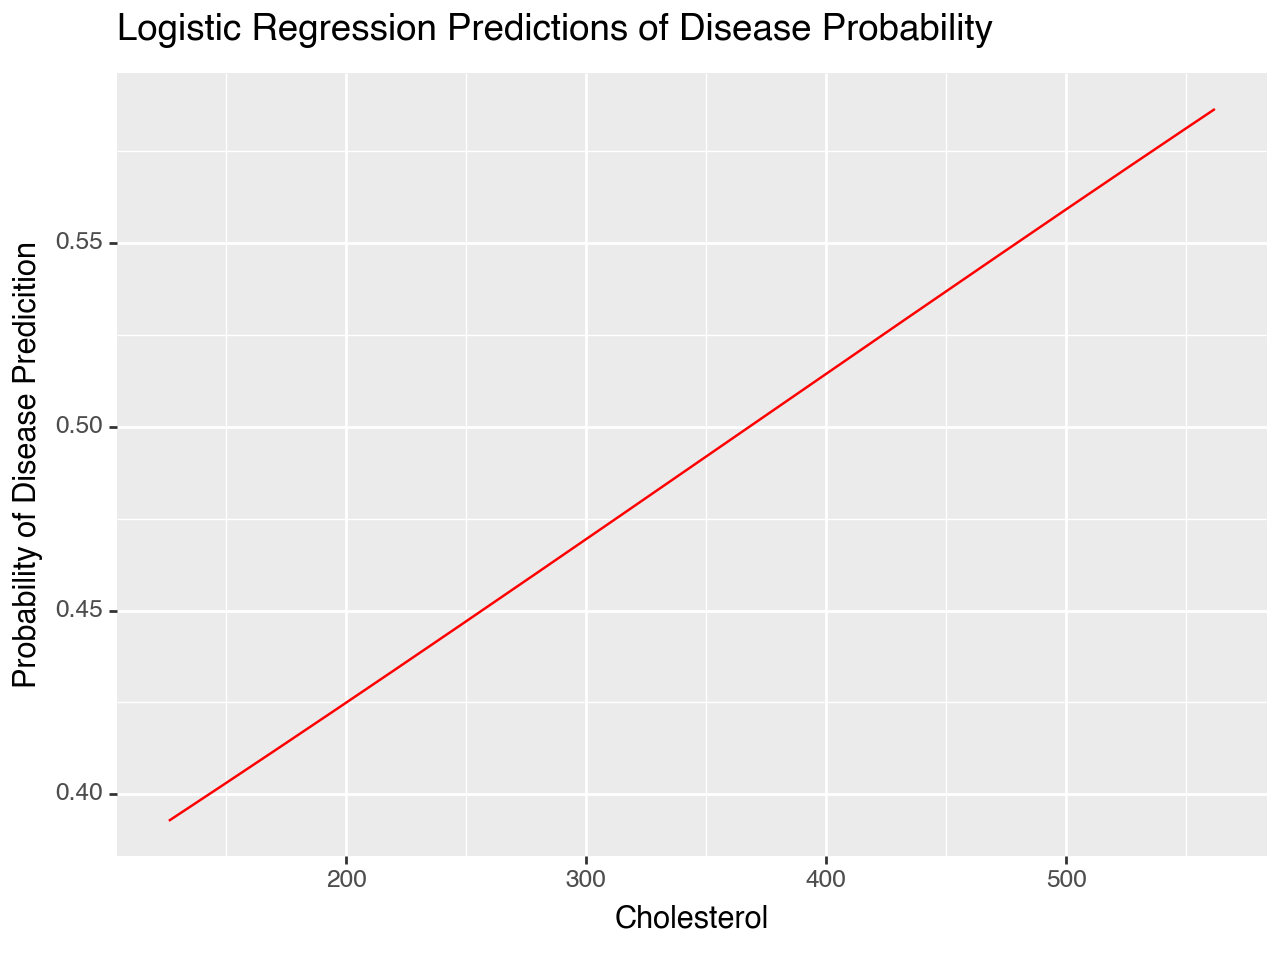

<Figure Size: (640 x 480)>

In [53]:
max_chol = heart_data['chol'].max()
min_chol = heart_data['chol'].min()

cholesterol_values = list(range(min_chol, max_chol, 2))

lr_predictions_df = pd.DataFrame({
    'age': [55] * len(cholesterol_values),
    'chol': cholesterol_values
})

y_probs_log = lr_pipeline.predict_proba(lr_predictions_df)[:, 1]

#Add predicted probabilities to data frame
lr_predictions_df['predicted_disease_prob'] = y_probs_log

lr_predictions_df

#Create plot
plot = (ggplot(lr_predictions_df, aes(x='chol', y='predicted_disease_prob'))
        + geom_line(color = "red")
        + labs(title="Logistic Regression Predictions of Disease Probability", x="Cholesterol", y="Probability of Disease Predicition")
       )
plot

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [54]:
# Create a pipeline with preprocessing and logistic regression
lda_pipeline = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('LDA', LinearDiscriminantAnalysis())
    ]
)

# Train the pipeline
lda_pipeline_fitted = lda_pipeline.fit(X, y)

In [55]:
# Generate coefficients for log regression step of pipeline
coef_2 = lda_pipeline_fitted.named_steps['LDA'].coef_

# Output coefficients for Age and Cholesterol
#coef_2
print(f"age Coefficient: {coef_2[0, 0]}")
print(f"chol Coeficient: {coef_2[0, 1]}")

# Generate intercepts for log regression step of pipeline
intercept_2 = lda_pipeline_fitted.named_steps["LDA"].intercept_
#intercept_2
print(f"Intercept: {intercept_2}")

age Coefficient: 0.04655743553694483
chol Coeficient: 0.0017896671039291288
Intercept: [-3.21967766]


In [56]:
#extract coefficients
lda_age_coef = coef_2[0, 0]
lda_chol_coef = coef_2[0, 1]
lda_inter = intercept_2

# For a 55 y/o, how high would their cholesterol need to be for the doctors to predict heart disease present?
age = 55
chol_disease = ((-lda_age_coef*age)-lda_inter)/lda_chol_coef

print(f"Cholesterol level for doctors to predict Heart Disease in 55 year old: {chol_disease}")

Cholesterol level for doctors to predict Heart Disease in 55 year old: [368.23535753]


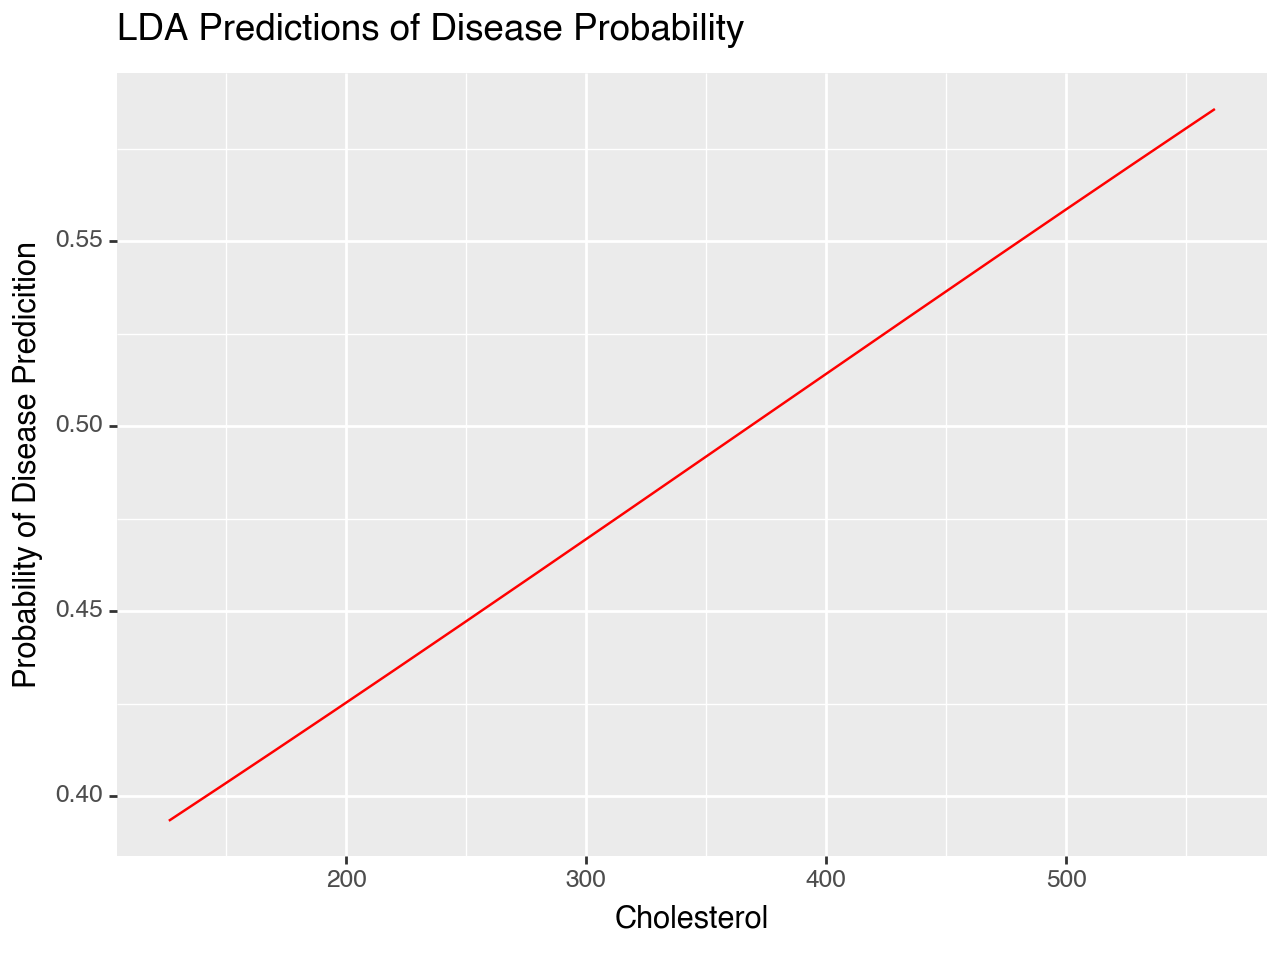

<Figure Size: (640 x 480)>

In [57]:
max_chol = heart_data['chol'].max()
min_chol = heart_data['chol'].min()

cholesterol_values = list(range(min_chol, max_chol, 2))

lda_predictions_df = pd.DataFrame({
    'age': [55] * len(cholesterol_values),
    'chol': cholesterol_values
})

y_probs_lda = lda_pipeline.predict_proba(lda_predictions_df)[:, 1]

#Add predicted probabilities to data frame
lda_predictions_df['predicted_disease_prob'] = y_probs_lda

lda_predictions_df

#Create plot
lda_plot = (ggplot(lda_predictions_df, aes(x='chol', y='predicted_disease_prob'))
        + geom_line(color = "red")
        + labs(title="LDA Predictions of Disease Probability", x="Cholesterol", y="Probability of Disease Predicition")
       )
lda_plot

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [58]:
# Create a pipeline with preprocessing and logistic regression
svc_pipeline = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('SVC', SVC(kernel = "linear"))
    ]
)

# Train the pipeline
svc_pipeline_fitted = svc_pipeline.fit(X, y)

In [59]:
# Generate coefficients for log regression step of pipeline
coef_3 = svc_pipeline_fitted.named_steps['SVC'].coef_

# Output coefficients for Age and Cholesterol
#coef_3
print(f"age Coefficient: {coef_3[0, 0]}")
print(f"chol Coeficient: {coef_3[0, 1]}")

# Generate intercepts for log regression step of pipeline
intercept_3 = svc_pipeline_fitted.named_steps["SVC"].intercept_
#intercept_3
print(f"Intercept: {intercept_3}")

age Coefficient: 0.06439813681981832
chol Coeficient: 0.003657758585177362
Intercept: [-4.68570382]


In [60]:
#define coefficients
svc_age_coef = coef_3[0, 0]
svc_chol_coef = coef_3[0, 1]
svc_inter = intercept_3

# For a 55 y/o, how high would their cholesterol need to be for the doctors to predict heart disease present?
age = 55
chol_disease = ((-svc_age_coef*age)-svc_inter)/svc_chol_coef

print(f"Cholesterol level for doctors to predict Heart Disease in 55 year old: {chol_disease}")

Cholesterol level for doctors to predict Heart Disease in 55 year old: [312.70688494]


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

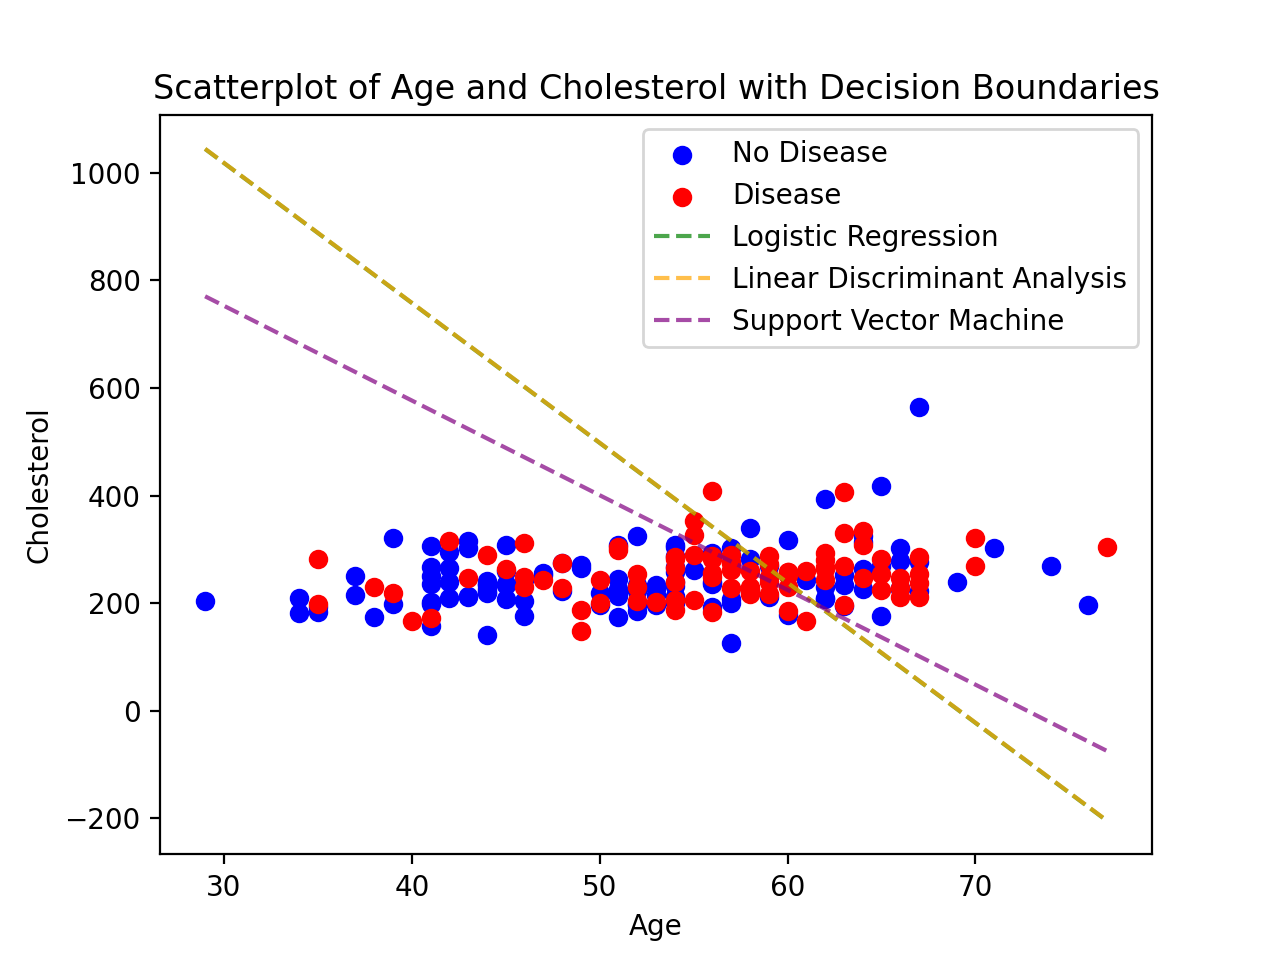

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Convert 'No Disease' to 0 and 'Disease' to 1
label_encoder = LabelEncoder()
heart_data['diagnosis'] = label_encoder.fit_transform(heart_data['diagnosis'])

# Scatterplot
plt.scatter(heart_data[heart_data['diagnosis'] == 0]['age'], heart_data[heart_data['diagnosis'] == 0]['chol'], label='No Disease', color='blue')
plt.scatter(heart_data[heart_data['diagnosis'] == 1]['age'], heart_data[heart_data['diagnosis'] == 1]['chol'], label='Disease', color='red')

# Decision boundary for logistic regression
x_lr = np.linspace(min(heart_data['age']), max(heart_data['age']), 100)
y_lr = (-lr_inter - lr_age_coef * x_lr) / lr_chol_coef
plt.plot(x_lr, y_lr, label='Logistic Regression', linestyle='--', color='green', alpha=0.7)

# Decision boundary for linear discriminant analysis
y_lda = (-lda_inter - lda_age_coef * x_lr) / lda_chol_coef
plt.plot(x_lr, y_lda, label='Linear Discriminant Analysis', linestyle='--', color='orange', alpha=0.7)

# Decision boundary for support vector machine
y_svc = (-svc_inter - svc_age_coef * x_lr) / svc_chol_coef
plt.plot(x_lr, y_svc, label='Support Vector Machine', linestyle='--', color='purple', alpha=0.7)

# Labels and legend
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.legend()
plt.title('Scatterplot of Age and Cholesterol with Decision Boundaries')
plt.show()